In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random

from tensorflow.python.client import device_lib


print(device_lib.list_local_devices())
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11255124151081641506
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10073663079
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17392171912724532231
physical_device_desc: "device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


### Undistort

In [61]:
import pickle
def cal_undistort(img,mtx,dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

17
17
17


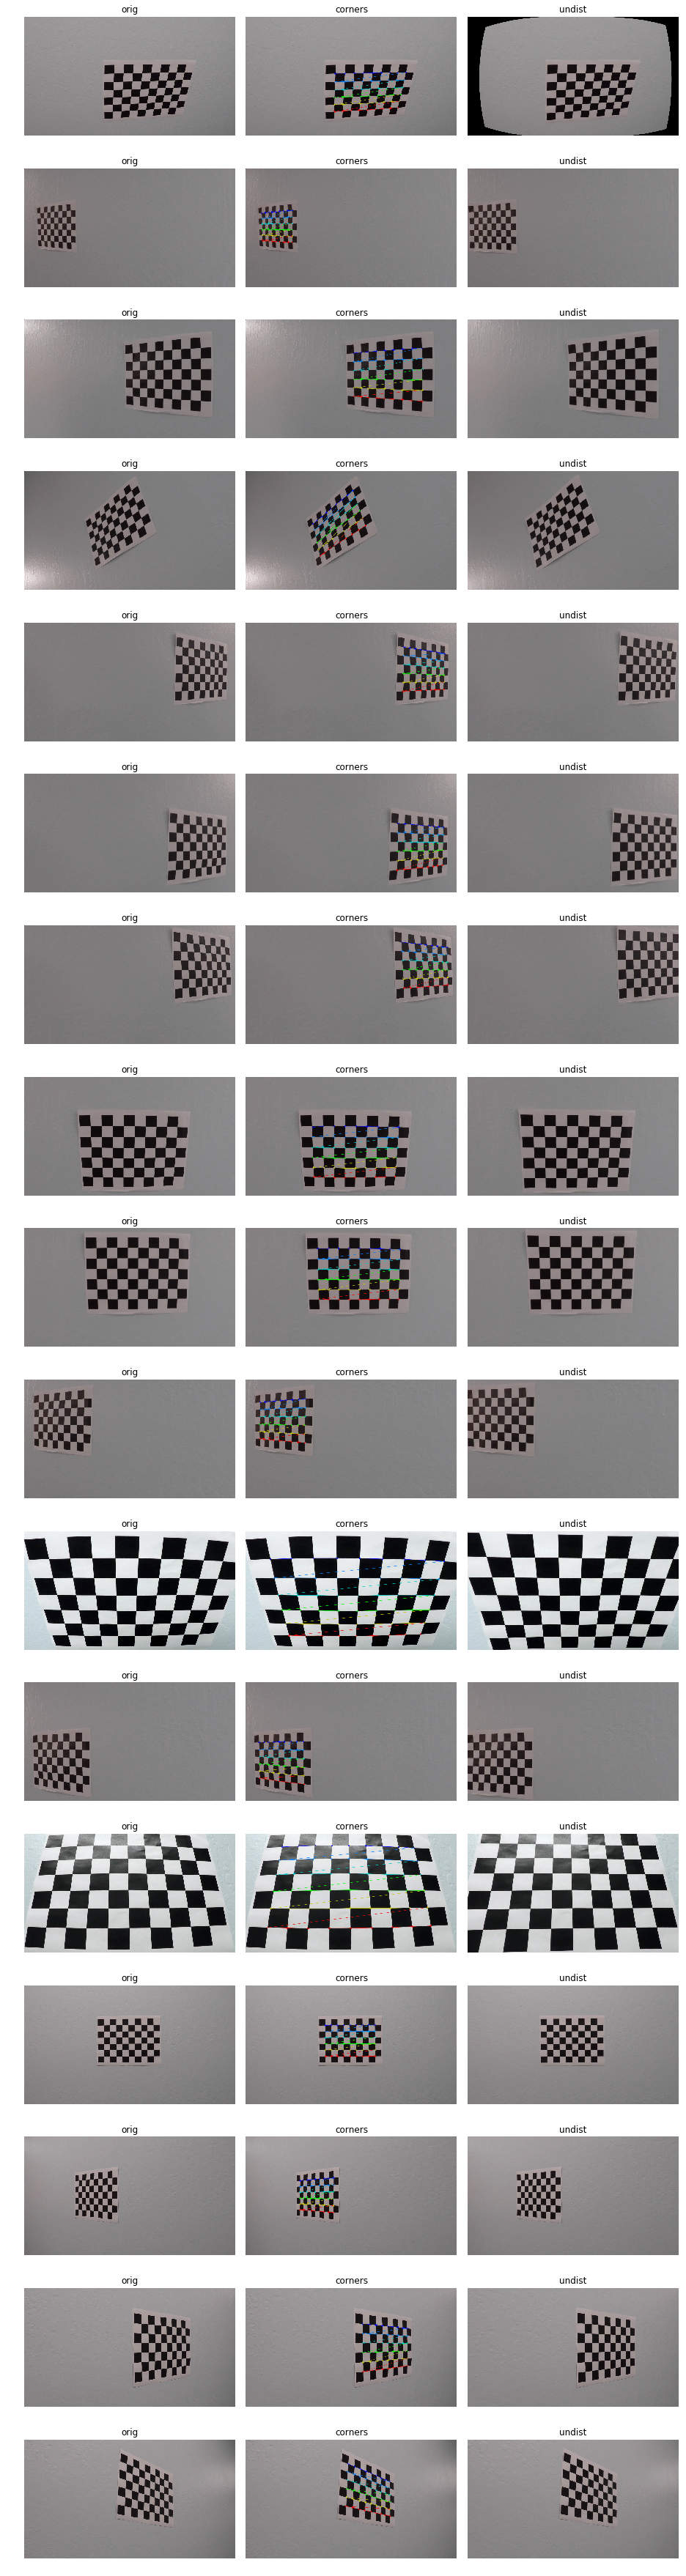

In [62]:
cv_img=[]
cv_orig=[]
cv_undist=[]

for img in glob.glob("camera_cal/calibration*.jpg"):
    n = cv2.imread(img)
 
    gray = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    count=0
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    # Draw and display the corners
        cv2.drawChessboardCorners(n, (nx, ny), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        cv_undist.append((cal_undistort(cv2.imread(img), mtx,dist)))
        #plt.imshow(n)
        cv_orig.append(cv2.imread(img))
        cv_img.append(n)
    #cv_img.append(gray)

print(len(cv_img))
print(len(cv_orig))
print(len(cv_undist))



fig, axs = plt.subplots(len(cv_img),3, figsize=(16, 64))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()
count=0
i=0
while i< len(cv_img):
   
    
    axs[count].axis('off')
    axs[count].set_title("orig")
    axs[count].imshow(cv_orig[i].squeeze())
    
    axs[count+1].axis('off')
    axs[count+1].set_title("corners")
    axs[count+1].imshow(cv_img[i].squeeze())
    
    axs[count+2].axis('off')
    axs[count+2].set_title("undist")
    axs[count+2].imshow(cv_undist[i].squeeze())
    i=i+1
    count=count+3
   
       


#### Test Calibration #1

Text(0.5,1,'Undistorted Image')

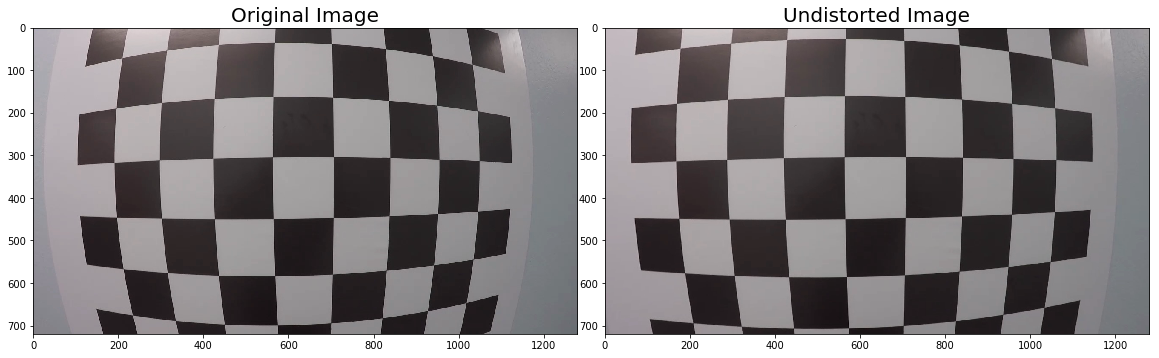

In [63]:
n = cv2.imread("camera_cal/calibration_test.png")
dst=cal_undistort(n, mtx,dist)
    #cv_img.append(gray)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(n)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)


#### Test Calibration #2

Text(0.5,1,'Undistorted Image')

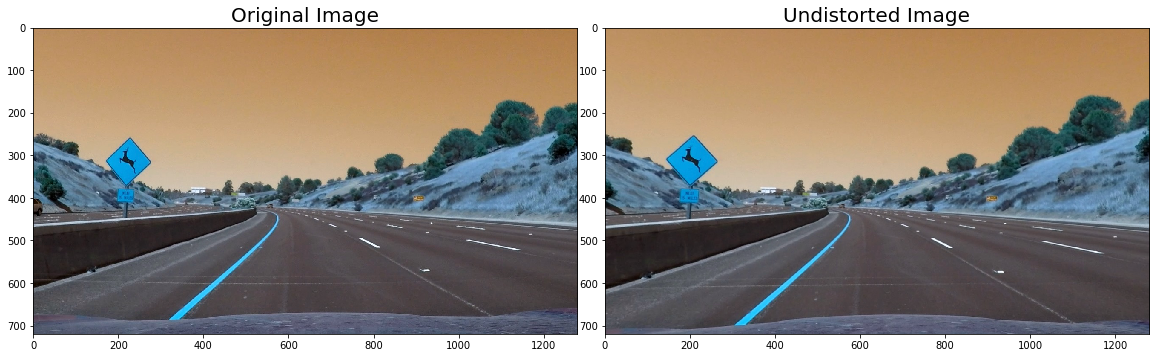

In [64]:
n = cv2.imread("test_images/test2.jpg")
un_dist=cal_undistort(n,  mtx,dist)
    #cv_img.append(gray)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(n)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(un_dist)
ax2.set_title('Undistorted Image', fontsize=20)


### Perspective transformation

In [65]:
#Transform
def warp(img, nx, ny): 
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M



### Convert to Binary Image - Sobel, Magnitude, Direction of gradient threshold 

In [66]:
from ipywidgets import interact, interactive, fixed

##### Sobel Threshold

In [67]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=25, thresh_max=255):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    
    # Sobel x
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
    # Sobel y
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold x gradient
    #thresh_min = thresh[0]
   # thresh_max = thresh[1]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary


In [68]:
def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = abs_sobel_thresh(un_dist, 'x',3,min_thresh, max_thresh)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(un_dist)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=20)

interact(update, 
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

...


##### Magnitude Threshold

In [69]:
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_magnitude = np.absolute(magnitude)
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    return mag_binary
    
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelMag = mag_thresh(un_dist, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(un_dist)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(exampleImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=20)

interact(update, kernel_size=(3,30,6), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))
    



interactive(children=(IntSlider(value=15, description='kernel_size', max=30, min=3, step=6), IntSlider(value=1…

<function __main__.update(kernel_size, min_thresh, max_thresh)>

##### Color Threshold

In [70]:
def color_threshold(img,s_thresh_min,s_thresh_max):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
 #   s_thresh_min = 185
 #   s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary
def update(s_min_thresh, s_max_thresh):
    exampleImg_col_thresh = color_threshold(un_dist, s_min_thresh,s_max_thresh)
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(un_dist)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(exampleImg_col_thresh, cmap='gray')
    ax2.set_title('HLS space - S Channel - Color Threshold', fontsize=20)
    
interact(update,s_min_thresh=(0,255), s_max_thresh=(0,255))

interactive(children=(IntSlider(value=127, description='s_min_thresh', max=255), IntSlider(value=127, descript…

<function __main__.update(s_min_thresh, s_max_thresh)>

In [71]:
def dir_threshold(img, sobel_kernel, thresh_min,thresh_max):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= thresh_min) & (arctan <= thresh_max)] = 1
    
    return dir_binary
def update(thresh_min,thresh_max):
    exampleImg_col_thresh = dir_threshold(un_dist,3, thresh_min,thresh_max)
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(un_dist)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(exampleImg_col_thresh, cmap='gray')
    ax2.set_title('Direction Threshold', fontsize=20)
interact(update,thresh_min=(0, np.pi/2),thresh_max=(0, np.pi/2))

interactive(children=(FloatSlider(value=0.7853981633974483, description='thresh_min', max=1.5707963267948966),…

<function __main__.update(thresh_min, thresh_max)>

In [72]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    return dir_binary
    
def combined_s_gradient_thresholds(img, show=False):
    # Choose a Sobel kernel size
    ksize = 27 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh_min=24, thresh_max=105)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh_min=24, thresh_max=105)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(58, 150))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 167
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    if show == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Actual image')
        ax1.imshow(img)
        ax2.set_title('Combined gradx,grady,magnitude,direction')
        ax2.imshow(combined, cmap='gray')
        ax3.set_title('Color thresholding')
        ax3.imshow(s_binary, cmap='gray')
        ax4.set_title('Combined all')
        ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary


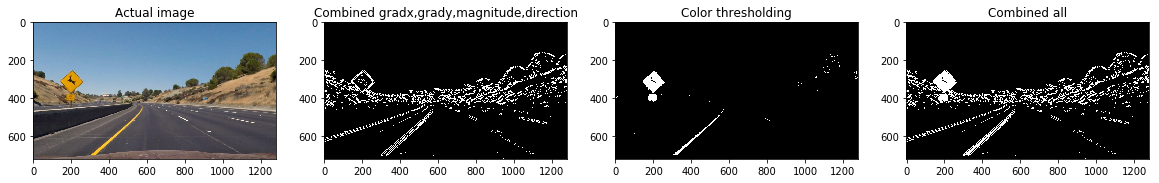

In [73]:
comb = combined_s_gradient_thresholds(un_dist, True)

### Test perspective transform on Binary Image

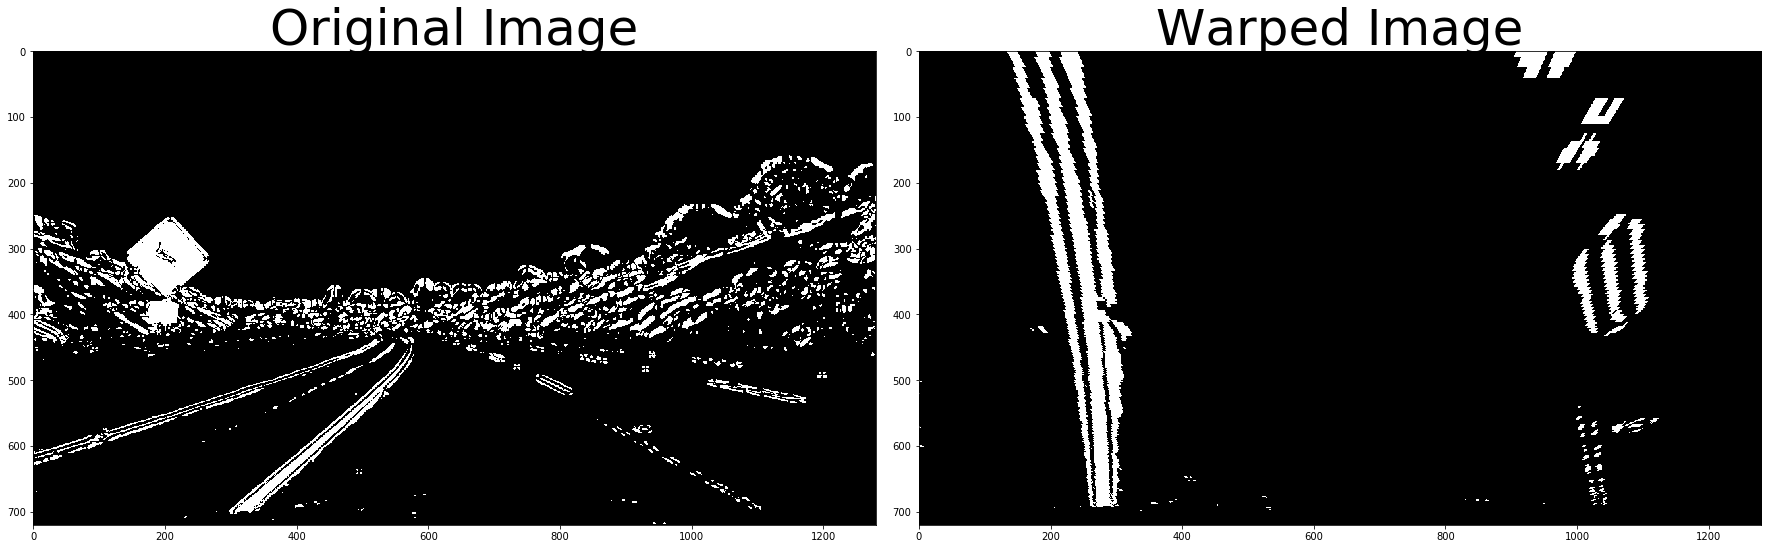

In [74]:
def visualize_transorm_image(combined_binary, warped_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

exampleImg_warp, M = warp(comb, nx, ny) 
visualize_transorm_image(comb, exampleImg_warp)


###  Histogram

269 1016


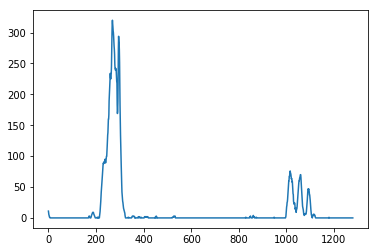

In [75]:
histogram = np.sum(exampleImg_warp[int(exampleImg_warp.shape[0]/2):,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

### Sliding fit Polynomial

In [76]:
def locate_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def locate_line_further(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new

In [77]:
def visualizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, binary_warped, nonzerox, nonzeroy, margin = 100):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


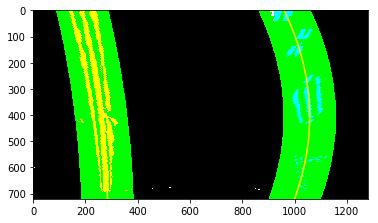

In [78]:


left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(exampleImg_warp) 
visualizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, exampleImg_warp, nonzerox, nonzeroy, margin = 100)

### Find Radius of Curvature of lanes

In [79]:
def radius_curvature(binary_warped, left_fit, right_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center 

In [80]:
left_curvature, right_curvature, center = radius_curvature(exampleImg_warp, left_fit, right_fit)

### Draw radius of curvature on Image

In [81]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values = False):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return result

array([[[ 96, 145, 188],
        [ 96, 145, 188],
        [ 95, 144, 187],
        ...,
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 96, 145, 188],
        [ 96, 145, 188],
        [ 95, 144, 187],
        ...,
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 96, 145, 188],
        [ 95, 144, 187],
        [ 94, 143, 186],
        ...,
        [ 78, 130, 179],
        [ 78, 130, 179],
        [ 78, 130, 179]],

       ...,

       [[ 97,  83,  96],
        [ 97,  83,  96],
        [ 98,  84,  96],
        ...,
        [122,  98,  88],
        [121,  97,  87],
        [119,  95,  85]],

       [[ 98,  85,  96],
        [ 99,  86,  97],
        [100,  87,  97],
        ...,
        [121,  97,  87],
        [120,  96,  86],
        [118,  94,  84]],

       [[102,  88,  98],
        [103,  88,  98],
        [104,  89,  99],
        ...,
        [116,  93,  85],
        [118,  95,  86],
        [118,  95,  86]]

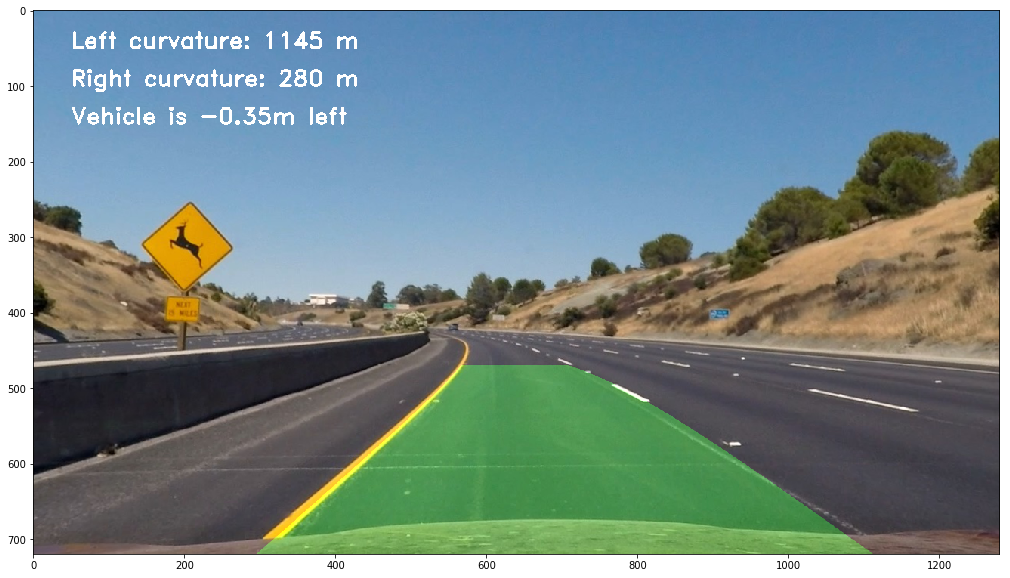

In [82]:

img = cv2.cvtColor(un_dist, cv2.COLOR_BGR2RGB)
draw_on_image(img, exampleImg_warp, left_fit, right_fit, M, left_curvature, right_curvature, center, True)

### Create Pipeline to process video

In [83]:
def is_lane_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: 
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        
        #Check if lines are parallel at the middle
        if delta_slope_mid <= 0.1:
            status = True
        else:
            status = False
            
    return status

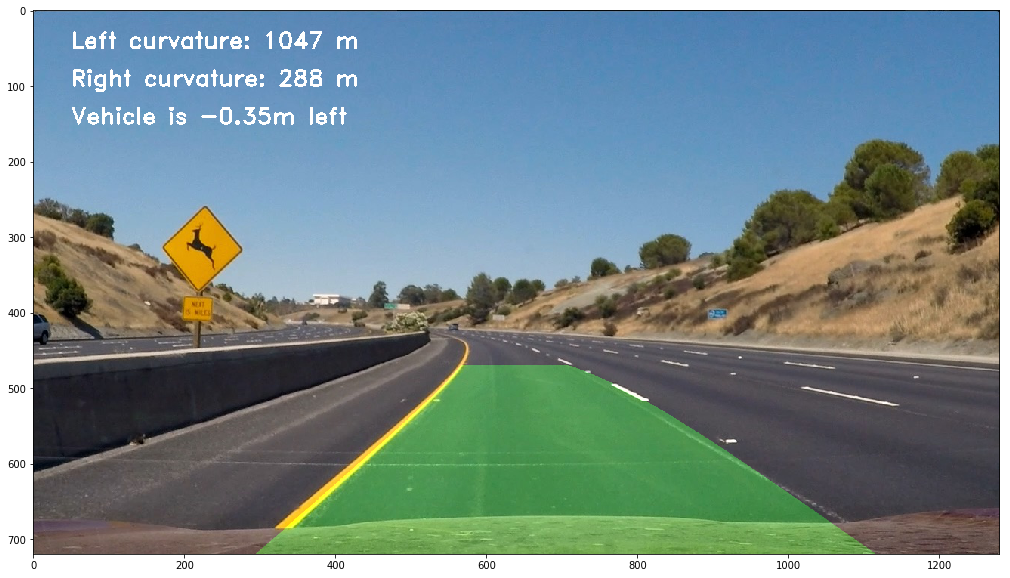

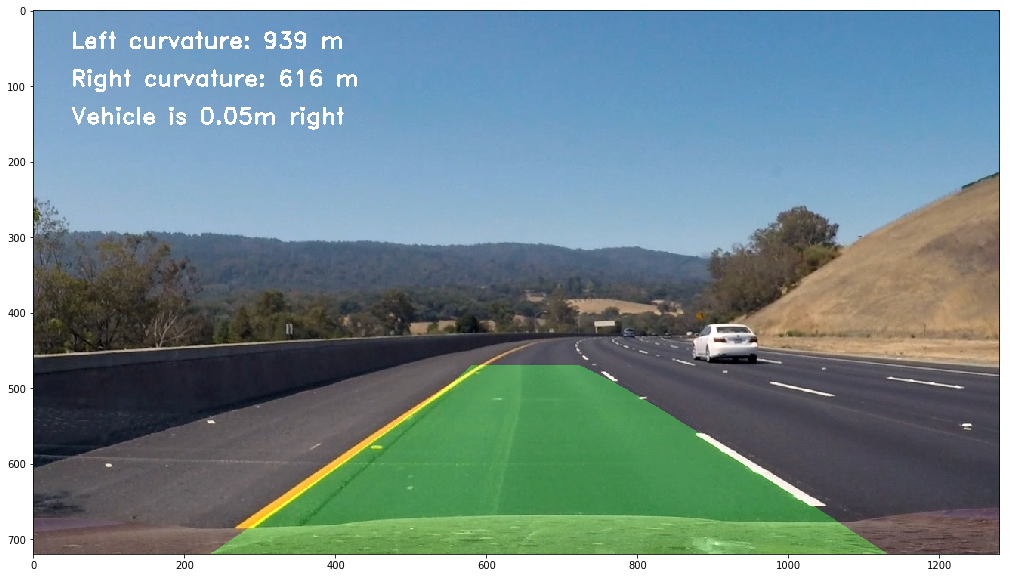

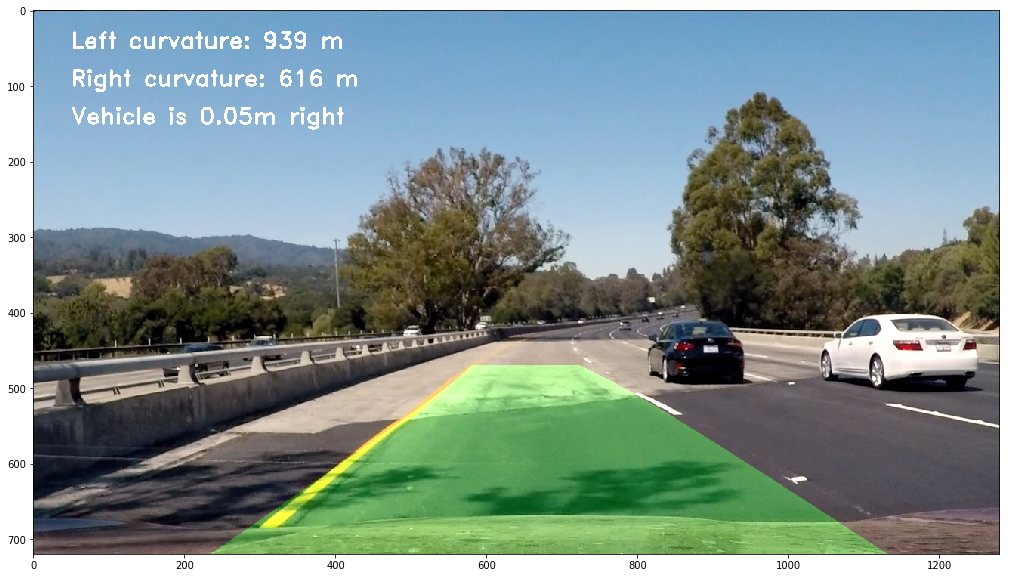

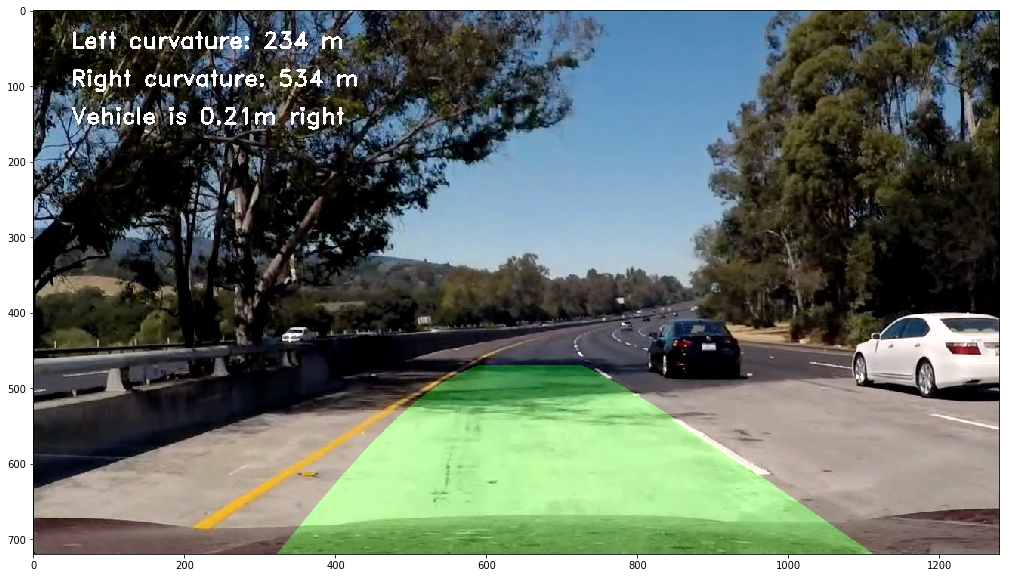

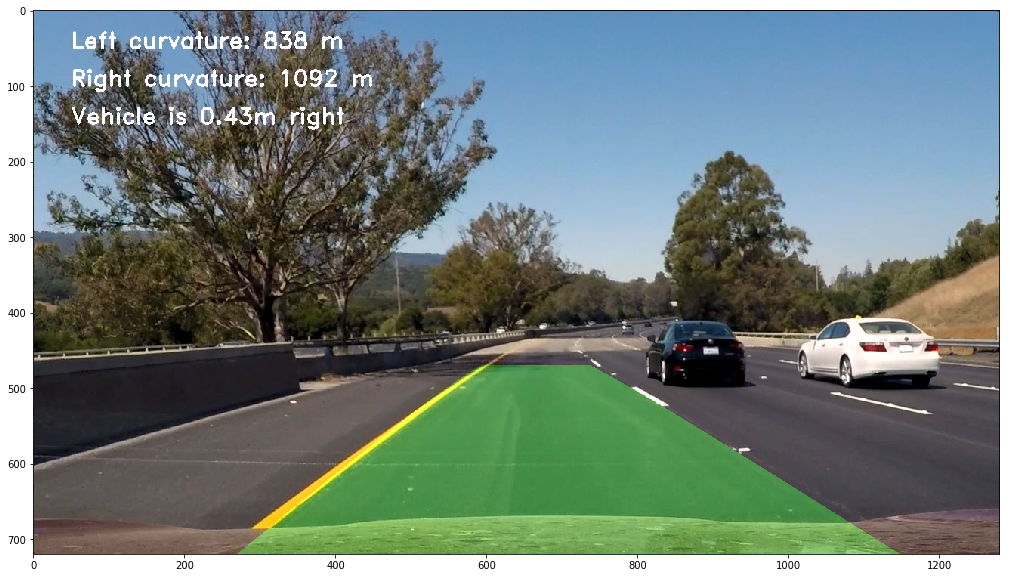

In [84]:
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        
lane = Lane()

def find_lanes(img):
    img = cal_undistort(img, mtx, dist)
    
    combined_binary = combined_s_gradient_thresholds(img)
   
    warped_img, M = warp(combined_binary, nx, ny)
  
    if lane.counter == 0:
        lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
    else:
        lane.left_fit, lane.right_fit  = locate_line_further(lane.left_fit, lane.right_fit, warped_img)
    
    #Sanity check
    status = is_lane_valid(lane.left_fit, lane.right_fit)
    
    if status == True:        
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else:   
        #Reset
        if lane.reset_counter > 4:
            lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
            lane.reset_counter = 0
        else:
            lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
            
        lane.reset_counter += 1
 
    return warped_img, lane.left_fit, lane.right_fit, M


def pipeline(img, show_values=False):
    warped_img, left_fit, right_fit, M = find_lanes(img)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)
    
    return draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values)
    
images = [  'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

for fname in images:
    img = cv2.imread('test_images/'+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    pipeline(img, True)


### Challenge-  Lanes detected fairly well

In [85]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [86]:
lane = Lane()
def process_image(img):
    return pipeline(img)

white_output = 'output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(post_process_vid ))

#### Harder Challenge- Not so great lane detection- Needs more work

In [ ]:
lane = Lane()
def process_image(img):
    return pipeline(img)

post_process_vid = 'output/harder_challenge_video.mp4'
pre_process_vid = VideoFileClip("harder_challenge_video.mp4")
process_video = pre_process_vid.fl_image(process_image)
%time process_video.write_videofile(post_process_vid, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(post_process_vid ))